In [5]:
#Всю информацию по предобработки смотри на 
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

In [39]:
Image(filename="./notMNIST_small/A/MDEtMDEtMDAudHRm.png")
#b = os.listdir('./notMNIST_small/A')

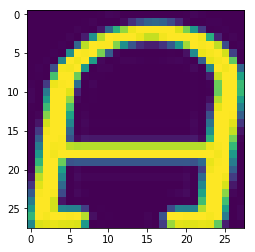

In [44]:
Image(filename="./notMNIST_large/A/a2F6b28udHRm.png")
train_datasets
test_datasets
pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image)


In [5]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 230000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (230000, 28, 28) (230000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [6]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [20]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [48]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1288844879


In [2]:
# read pickle file
with open('notMNIST_cor1.pickle', 'rb') as f:
    dataset = pickle.load(f)
dataset_key = dataset.keys()

train_dataset, train_labels = dataset['train_dataset'], dataset['train_labels']
valid_dataset, valid_labels = dataset['valid_dataset'], dataset['valid_labels']
test_dataset, test_labels = dataset['test_dataset'], dataset['test_labels']

del dataset

# merge valid_dataset and test_dataset
# test_dataset, test_labels = np.concatenate((valid_dataset, test_dataset), axis=0), np.concatenate((valid_labels, test_labels), axis=0)
# print(test_dataset.shape, test_labels.shape)

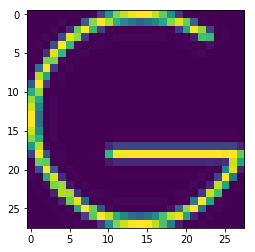

label 6.0


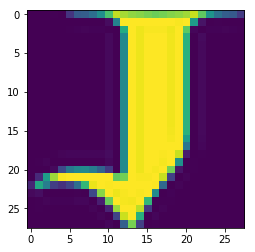

label 9.0


In [36]:
# убеждаюсь, что метки  и изображения совпадают
plt.imshow(test_dataset[10, : :])
plt.show()

print("label {}".format(test_labels[10]))

plt.imshow(train_dataset[10020, : :])
plt.show()

print("label {}".format(train_labels[10020]))

In [8]:
# избавимся от перекрытий между множества train cv test
# вытигиваем изображения в вектор и добавляем метку
new_train = np.concatenate((train_dataset.reshape(train_dataset.shape[0], -1), np.array([train_labels]).T), axis=1)
new_valid = np.concatenate((valid_dataset.reshape(valid_dataset.shape[0], -1), np.array([valid_labels]).T), axis=1)
new_test = np.concatenate((test_dataset.reshape(test_dataset.shape[0], -1), np.array([test_labels]).T), axis=1)
new_big_matrix = np.concatenate((new_train, new_valid, new_test))
shapes = new_big_matrix.shape[0]

#объединяем все в 1 большой массив
new_big_matrix = np.concatenate((new_train, new_valid, new_test))
new_big_matrix = np.unique(new_big_matrix, axis=0)

print("Количество повторных изображений {}".format(shapes - new_big_matrix.shape[0]))
print("Всего количество примеров {}".format(new_big_matrix.shape[0]))
train_ex, valid_ex = map(int, input("Введите размеры m подмножеств train, cv, через пробел:").split())

# перемешиваем примеры
np.random.shuffle(new_big_matrix)
# new_big_matrix.shape

# формируем метки
train_labels, valid_labels, test_labels = new_big_matrix[0:train_ex, 784], new_big_matrix[train_ex:(train_ex + valid_ex), 784], new_big_matrix[(train_ex + valid_ex):, 784]
new_big_matrix = new_big_matrix[:, :784]

big_matrix = np.zeros((new_big_matrix.shape[0], 28, 28))

for i in range(big_matrix.shape[0]):
    big_matrix[i] = new_big_matrix[i].reshape(28, 28)
# формируем изображения
train_dataset = big_matrix[0:train_ex]
valid_dataset = big_matrix[train_ex:(train_ex + valid_ex)]
test_dataset = big_matrix[(train_ex + valid_ex):]

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Введите размеры m подмножеств train, cv, через запятую:200000 15000
Training: (200000, 28, 28) (200000,)
Validation: (15000, 28, 28) (15000,)
Testing: (16355, 28, 28) (16355,)


In [9]:
# запись корректных данных
data_root = '.'
pickle_file = os.path.join(data_root, 'notMNIST_cor1.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

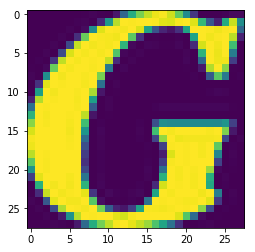

label 6.0


In [29]:
# проверка, что все было сделано верно по работе с удаленным пересающихся примеров
plt.imshow(valid_dataset[400])
plt.show()

print('label {}'.format(valid_labels[400]))

In [8]:
# Multinomial LogisticRegression
from sklearn.model_selection import learning_curve

params = [{'solver': 'newton-cg'},
          {'solver': 'lbfgs'},
          {'solver': 'sag'},
          {'solver': 'saga'}]
clfs = []
for param in params:
    clf = LogisticRegression(random_state=1, multi_class='multinomial', verbose=True, max_iter = 50, tol=1e-4 , **param).fit(
        train_dataset.reshape(train_dataset.shape[0], -1), train_labels)
    clfs.append(clf)

#     print("Первые 10 меток на обучение {}".format(train_labels[0:10]))
#     print("Первые 10 предсказанных меток на обучение {}".format(clf.predict(train_dataset.reshape(train_dataset.shape[0], -1))[0:10]))
#     print("Первые 10 меток на тесте {}".format(test_labels[0:10]))
#     print("Первые 10 предсказанных меток на тесте {}".format(clf.predict(test_dataset.reshape(test_dataset.shape[0], -1))[0:10]))
    print("В качестве оптимизатора {}. Доля правильных ответов на обучающей выборки {}".format(param.get('solver'), clf.score(train_dataset.reshape(train_dataset.shape[0], -1), train_labels)))
    print("Доля правильных ответов на кросс валидации {}".format(clf.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)))


    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 22.0min finished


В качестве оптимизатора newton-cg. Доля правильных ответов на обучающей выборки 0.83493
Доля правильных ответов на кросс валидации 0.8336


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.5s finished


В качестве оптимизатора lbfgs. Доля правильных ответов на обучающей выборки 0.831265
Доля правильных ответов на кросс валидации 0.8347333333333333


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 369 seconds


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished


В качестве оптимизатора sag. Доля правильных ответов на обучающей выборки 0.834955
Доля правильных ответов на кросс валидации 0.8337333333333333


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 887 seconds


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.8min finished


В качестве оптимизатора saga. Доля правильных ответов на обучающей выборки 0.834945
Доля правильных ответов на кросс валидации 0.8335333333333333


In [12]:
print("Доля правильных ответов на тестововм множестве {}".format(clfs[1].score(test_dataset.reshape(test_dataset.shape[0], -1), test_labels)))

Доля правильных ответов на тестововм множестве 0.8316111280953836


In [34]:
import sklearn

from sklearn.neural_network import MLPClassifier


params = [{'solver': 'adam', 'alpha': 1e-05, 'batch_size': 128, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 
           'activation': 'relu', 'hidden_layer_sizes': (50, 30), 'shuffle': True, 'learning_rate_init': 0.001}, 
          {'solver': 'adam', 'alpha': 1e-04, 'batch_size': 256, 'beta_1': 0.92, 'epsilon': 1e-08, 'beta_2': 0.995, 
           'activation': 'logistic', 'hidden_layer_sizes': (40, 30, 20), 'shuffle': True, 'learning_rate_init': 0.01},
          {'solver': 'adam', 'alpha': 1e-03, 'batch_size': 128, 'beta_1': 0.9, 'epsilon': 1e-08,'beta_2': 0.999,
           'activation': 'tanh', 'shuffle': True, 'hidden_layer_sizes': ( 40, 40, 30, 20), 'learning_rate_init': 0.005},
          {'solver': 'sgd', 'alpha': 1e-03, 'batch_size': 128, 'activation': 'logistic', 
           'momentum': 0.9, 'nesterovs_momentum': True,'shuffle': True, 
           'hidden_layer_sizes': (50, 30), 'learning_rate_init': 0.01},
          {'solver': 'sgd', 'alpha': 1e-04, 'batch_size': 128, 'activation': 'relu', 
           'momentum': 0.92, 'nesterovs_momentum': False,'shuffle': True, 
           'hidden_layer_sizes': (40, 30, 20), 'learning_rate_init': 0.01},
          {'solver': 'sgd', 'alpha': 1e-03, 'batch_size': 128, 'activation': 'tanh', 
           'momentum': 0.92, 'nesterovs_momentum': True,'shuffle': True, 
           'hidden_layer_sizes': ( 40, 40, 30, 20), 'learning_rate_init': 0.005},
          {'solver': 'lbfgs', 'alpha': 1e-05, 'activation': 'relu',
           'hidden_layer_sizes': (50, 30), 'learning_rate_init': 0.001},
          {'solver': 'lbfgs', 'alpha': 1e-04, 'activation': 'tanh', 
           'hidden_layer_sizes': (40, 30, 20), 'learning_rate_init': 0.01}]


labels_adam = ["adam1, architecture=(50, 30)", "adam2, architecture=(40, 30, 20)","adam3, architecture=(40, 40, 30, 20)"]
labels_sgd = ["sgd1, architecture=(50, 30)", "sgd2, architecture=(40, 30, 20)","sgd3, architecture=(40, 40, 30, 20)"]


plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': ':'}]

clfs = []
for param in params:
    clf = MLPClassifier(early_stopping=True, max_iter=30, n_iter_no_change=20, tol=1e-5, random_state=1, 
                        validation_fraction=0.1, verbose=True, warm_start=False, **param)
    clf.fit(train_dataset.reshape(train_dataset.shape[0], -1), train_labels)

    print("В качестве оптимизатора {}. Доля правильных ответов на обучающей выборки {}".format(param.get('solver'), clf.score(train_dataset.reshape(train_dataset.shape[0], -1), train_labels)))
    print("Доля правильных ответов на кросс валидации {}".format(clf.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)))

    clfs.append(clf)


Iteration 1, loss = 0.55478703
Validation score: 0.859600
Iteration 2, loss = 0.44704353
Validation score: 0.870200
Iteration 3, loss = 0.41410900
Validation score: 0.874800
Iteration 4, loss = 0.39424671
Validation score: 0.875950
Iteration 5, loss = 0.37982959
Validation score: 0.875150
Iteration 6, loss = 0.36890363
Validation score: 0.880350
Iteration 7, loss = 0.35914226
Validation score: 0.877950
Iteration 8, loss = 0.35242763
Validation score: 0.881550
Iteration 9, loss = 0.34648661
Validation score: 0.879300
Iteration 10, loss = 0.33980382
Validation score: 0.883000
Iteration 11, loss = 0.33543231
Validation score: 0.883350
Iteration 12, loss = 0.33047205
Validation score: 0.882900
Iteration 13, loss = 0.32667025
Validation score: 0.883600
Iteration 14, loss = 0.32250309
Validation score: 0.881700
Iteration 15, loss = 0.31926091
Validation score: 0.882300
Iteration 16, loss = 0.31597355
Validation score: 0.884300
Iteration 17, loss = 0.31301513
Validation score: 0.881850
Iterat

d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.90735
Доля правильных ответов на кросс валидации 0.8828
Iteration 1, loss = 0.76542173
Validation score: 0.838250
Iteration 2, loss = 0.50650147
Validation score: 0.847900
Iteration 3, loss = 0.47800102
Validation score: 0.852650
Iteration 4, loss = 0.46176136
Validation score: 0.854600
Iteration 5, loss = 0.44926834
Validation score: 0.857850
Iteration 6, loss = 0.44182448
Validation score: 0.857300
Iteration 7, loss = 0.43486824
Validation score: 0.859900
Iteration 8, loss = 0.42878968
Validation score: 0.860600
Iteration 9, loss = 0.42404666
Validation score: 0.862000
Iteration 10, loss = 0.42152109
Validation score: 0.863400
Iteration 11, loss = 0.41785934
Validation score: 0.862000
Iteration 12, loss = 0.41271164
Validation score: 0.861200
Iteration 13, loss = 0.41026679
Validation score: 0.864250
Iteration 14, loss = 0.40617775
Validation score: 0.863450
Iteration 15, loss = 0.40367954
Validation score: 

d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.88361
Доля правильных ответов на кросс валидации 0.8654
Iteration 1, loss = 0.59873646
Validation score: 0.838850
Iteration 2, loss = 0.51867522
Validation score: 0.844950
Iteration 3, loss = 0.50533615
Validation score: 0.845150
Iteration 4, loss = 0.50256874
Validation score: 0.848700
Iteration 5, loss = 0.49563086
Validation score: 0.848250
Iteration 6, loss = 0.49179727
Validation score: 0.851900
Iteration 7, loss = 0.49190756
Validation score: 0.850000
Iteration 8, loss = 0.49161707
Validation score: 0.852550
Iteration 9, loss = 0.49289682
Validation score: 0.851450
Iteration 10, loss = 0.48982260
Validation score: 0.854650
Iteration 11, loss = 0.48763244
Validation score: 0.848800
Iteration 12, loss = 0.49046664
Validation score: 0.852850
Iteration 13, loss = 0.48883708
Validation score: 0.853700
Iteration 14, loss = 0.49003973
Validation score: 0.852200
Iteration 15, loss = 0.48767714
Validation score: 

d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.86309
Доля правильных ответов на кросс валидации 0.8584
Iteration 1, loss = 1.48825373
Validation score: 0.787300
Iteration 2, loss = 0.75866498
Validation score: 0.818700
Iteration 3, loss = 0.65823531
Validation score: 0.829750
Iteration 4, loss = 0.60907450
Validation score: 0.836300
Iteration 5, loss = 0.57729980
Validation score: 0.841750
Iteration 6, loss = 0.55392379
Validation score: 0.846050
Iteration 7, loss = 0.53581010
Validation score: 0.848850
Iteration 8, loss = 0.52098812
Validation score: 0.851350
Iteration 9, loss = 0.50816827
Validation score: 0.852950
Iteration 10, loss = 0.49680640
Validation score: 0.855100
Iteration 11, loss = 0.48686564
Validation score: 0.855400
Iteration 12, loss = 0.47793093
Validation score: 0.858250
Iteration 13, loss = 0.46963021
Validation score: 0.859700
Iteration 14, loss = 0.46233744
Validation score: 0.860700
Iteration 15, loss = 0.45564910
Validation score: 

d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора sgd. Доля правильных ответов на обучающей выборки 0.883065
Доля правильных ответов на кросс валидации 0.8744
Iteration 1, loss = 0.61334801
Validation score: 0.853100
Iteration 2, loss = 0.46363506
Validation score: 0.862300
Iteration 3, loss = 0.42869953
Validation score: 0.871250
Iteration 4, loss = 0.40842730
Validation score: 0.871850
Iteration 5, loss = 0.39368831
Validation score: 0.876700
Iteration 6, loss = 0.38338548
Validation score: 0.877300
Iteration 7, loss = 0.37460301
Validation score: 0.878950
Iteration 8, loss = 0.36796878
Validation score: 0.880100
Iteration 9, loss = 0.36124247
Validation score: 0.878700
Iteration 10, loss = 0.35566074
Validation score: 0.879050
Iteration 11, loss = 0.35201831
Validation score: 0.880050
Iteration 12, loss = 0.34747837
Validation score: 0.881200
Iteration 13, loss = 0.34323860
Validation score: 0.882650
Iteration 14, loss = 0.34037782
Validation score: 0.880950
Iteration 15, loss = 0.33585265
Validation score: 

d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора sgd. Доля правильных ответов на обучающей выборки 0.90417
Доля правильных ответов на кросс валидации 0.8826
Iteration 1, loss = 0.69044118
Validation score: 0.843500
Iteration 2, loss = 0.52367392
Validation score: 0.848200
Iteration 3, loss = 0.48508996
Validation score: 0.855200
Iteration 4, loss = 0.45911903
Validation score: 0.861700
Iteration 5, loss = 0.43997848
Validation score: 0.865000
Iteration 6, loss = 0.42476439
Validation score: 0.867100
Iteration 7, loss = 0.41227654
Validation score: 0.869200
Iteration 8, loss = 0.40145405
Validation score: 0.870150
Iteration 9, loss = 0.39229430
Validation score: 0.872250
Iteration 10, loss = 0.38485851
Validation score: 0.871950
Iteration 11, loss = 0.37774843
Validation score: 0.873200
Iteration 12, loss = 0.37168232
Validation score: 0.873100
Iteration 13, loss = 0.36547863
Validation score: 0.873300
Iteration 14, loss = 0.36103101
Validation score: 0.876950
Iteration 15, loss = 0.35635849
Validation score: 0

d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора sgd. Доля правильных ответов на обучающей выборки 0.902725
Доля правильных ответов на кросс валидации 0.8754
В качестве оптимизатора lbfgs. Доля правильных ответов на обучающей выборки 0.85127
Доля правильных ответов на кросс валидации 0.8514
В качестве оптимизатора lbfgs. Доля правильных ответов на обучающей выборки 0.84554
Доля правильных ответов на кросс валидации 0.8456


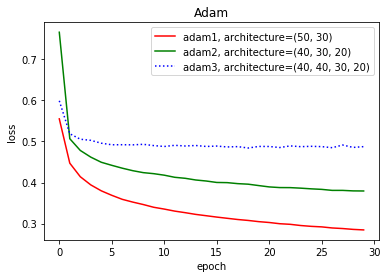

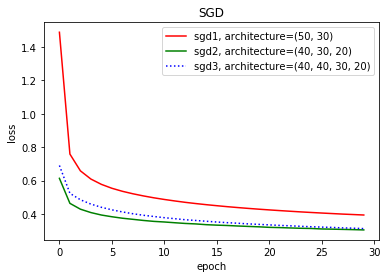

In [35]:
plot_args[0]
plt.figure()
plt.title("Adam")
plt.plot(clfs[0].loss_curve_, **plot_args[0])
plt.plot(clfs[1].loss_curve_, **plot_args[1])
plt.plot(clfs[2].loss_curve_, **plot_args[2])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(labels_adam, loc='best')
plt.show()


plt.figure()
plt.title("SGD")
plt.legend(labels_adam, loc='best')
plt.plot(clfs[3].loss_curve_, **plot_args[0])
plt.plot(clfs[4].loss_curve_, **plot_args[1])
plt.plot(clfs[5].loss_curve_, **plot_args[2])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(labels_sgd, loc='best')
plt.show()


In [41]:
# делаем вывод, что дальше работаем с 1 моделью, так как она имеет более низкую loss + на cv показала лучший результат 88.28
# попробуем ее улучшить
import sklearn

from sklearn.neural_network import MLPClassifier

learning_rates = [0.01, 0.005, 0.001]
alphas = [0.05, 0.01, 0.005, 0.001, 0.0001, 0.00001]
clfs = []
for learning_rate in learning_rates:
    for alpha in alphas:
        param = {'solver': 'adam', 
                 'alpha': alpha, 
                 'batch_size': 128, 
                 'beta_1': 0.9, 
                 'beta_2': 0.999, 
                 'epsilon': 1e-08, 
                 'activation': 'relu', 
                 'hidden_layer_sizes': (50, 30), 
                 'shuffle': True, 
                 'learning_rate_init': learning_rate}

        clf = MLPClassifier(early_stopping=True, max_iter=50, n_iter_no_change=20, tol=1e-5, random_state=1, 
                            validation_fraction=0.1, verbose=False, warm_start=False, **param)
        clf.fit(train_dataset.reshape(train_dataset.shape[0], -1), train_labels)

        print("В качестве оптимизатора {}. Доля правильных ответов на обучающей выборки {}".format(param.get('solver'), clf.score(train_dataset.reshape(train_dataset.shape[0], -1), train_labels)))
        print("Доля правильных ответов на кросс валидации {}".format(clf.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)))

        clfs.append(clf)

В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.851355
Доля правильных ответов на кросс валидации 0.851


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.869635
Доля правильных ответов на кросс валидации 0.8653
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.87242
Доля правильных ответов на кросс валидации 0.8677


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.887485
Доля правильных ответов на кросс валидации 0.8762


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.891005
Доля правильных ответов на кросс валидации 0.8699
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.885995
Доля правильных ответов на кросс валидации 0.8686


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.875735
Доля правильных ответов на кросс валидации 0.8727


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.891415
Доля правильных ответов на кросс валидации 0.8805


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.89276
Доля правильных ответов на кросс валидации 0.8827


d:\учёба\магистратура\____аспирантура\___keras\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.90157
Доля правильных ответов на кросс валидации 0.8798
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.88922
Доля правильных ответов на кросс валидации 0.8779
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.897185
Доля правильных ответов на кросс валидации 0.8766
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.902035
Доля правильных ответов на кросс валидации 0.8861
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.910545
Доля правильных ответов на кросс валидации 0.8861
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.89926
Доля правильных ответов на кросс валидации 0.8825
В качестве оптимизатора adam. Доля правильных ответов на обучающей выборки 0.907775
Доля правильных ответов на кросс валидации 0.8842
В качестве оптимизатора adam. Доля правильных ответов на обучающе

In [ ]:
plt.figure()
plt.title("SGD")
plt.legend(labels_adam, loc='best')
plt.plot(clfs[3].loss_curve_, **plot_args[0])
plt.plot(clfs[4].loss_curve_, **plot_args[1])
plt.plot(clfs[5].loss_curve_, **plot_args[2])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(labels_sgd, loc='best')
plt.show()

(200000, 1, 28, 28) X_train.shape
200000 train_samples
15000 valid_samples
Train on 190000 samples, validate on 10000 samples
Epoch 1/1
15000/15000 [==============================] - 20s 1ms/step
CV cost_function: 0.2935501758982738
CV accuracy: 0.9123333333015442


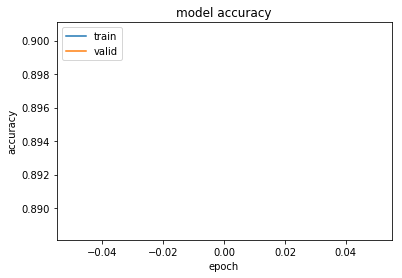

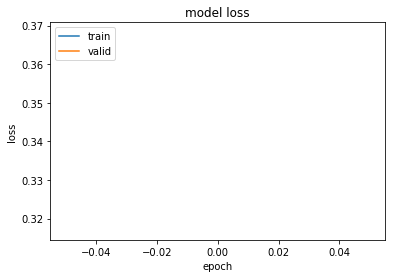

In [9]:
# с помощью Keras
from keras import backend as k
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt


# Часть 1 -подготовка
# сеть и ее обучение
NB_EPOCH = 1
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASES = 10 #количество классов
# OPTIMIZER = SGD() # в качестве оптимизатора стохастический градиентный спуск
OPTIMIZER = Adam(lr=0.003)# в качестве оптимизатора стохастический градиентный спуск
# lr - скорость сходимости
#OPTIMIZER = RMSprop() # в качестве оптимизатора стохастический градиентный спуск
VALIDATION_SPLIT = 0.05 #сколько выделить примеров из обучающего набора на кросс-валидацию
IMG_ROWS, IMG_COLS = 28, 28 #размер входного изображения
INPUT_SHAPE = [1, IMG_ROWS, IMG_COLS]
k.set_image_dim_ordering("th")

# загружаем данные и перемешиваем и делим на обучение и тест
(X_train, y_train), (X_valid, y_valid) = (train_dataset, train_labels), (valid_dataset, valid_labels)

# нам нужна форма 60К * [1*28*28], подаваемая на вход CNN
X_train = X_train[:, np.newaxis, :, :]
X_valid = X_valid[:, np.newaxis, :, :]

# для ядра tf меняем размерность изображений
# k.set_image_dim_ordering("tf")
# INPUT_SHAPE = [IMG_ROWS, IMG_COLS, 1]
# X_train = np.transpose(X_train, (0, 2, 3, 1))
# X_valid = np.transpose(X_valid, (0, 2, 3, 1))

print(X_train.shape, 'X_train.shape')
print(X_train.shape[0], 'train_samples')
print(X_valid.shape[0], 'valid_samples')

# унитарное кодирование меток - преобразование векторов классов в бинарные матрицы классов
Y_train = np_utils.to_categorical(y_train, NB_CLASES)
Y_valid = np_utils.to_categorical(y_valid, NB_CLASES)

# часть 2 - архитектура сети
class CNN:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        # CONV => RELU => POOL
        model = Sequential()
        # CONV => RELU => POOL
        model.add(Conv2D(20, kernel_size=5, padding='same', input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # CONV => RELU => POOL
        model.add(Conv2D(50, kernel_size=5, padding='same', input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        # слои Flatten => RELU
        # Flatten - слой уплотнения (то есть мы берем и вытягиваем получившиеся признаки в вектор
        # строку размрености (50*7*7, ))
        model.add(Flatten())
        #  и плотный слой с 500 нейронами
        model.add(Dense(500, activation='relu'))
        # softmax -классификатор   
        model.add(Dense(classes, activation='softmax'))
        return model

# инициализируем оптимизатор и модель
model = CNN.build(input_shape=INPUT_SHAPE, classes=NB_CLASES)
# орпеделеяем метод оптимизации и функцию потерь.
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
# обучение модели
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
# вывод результатов работы
score = model.evaluate(X_valid, Y_valid, verbose=VERBOSE)
print("CV cost_function:", score[0])
print("CV accuracy:", score[1])

# построить график изменения accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# построить график изменения функии потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [10]:
#проверка на тесте

X_test = test_dataset[:, np.newaxis, :, :]
Y_test = np_utils.to_categorical(test_labels, 10)

score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print("TEST cost_function:", score[0])
print("TEST accuracy:", score[1])

16355/16355 [==============================] - 22s 1ms/step
TEST cost_function: 0.2936185056466674
TEST accuracy: 0.9093243656374197


In [43]:
history.history

{'val_loss': [0.28921276502609256, 0.2644384395599365, 0.26127655906677244],
 'val_acc': [0.9137, 0.9228, 0.9249],
 'loss': [0.38116990103219683, 0.26166195126332736, 0.21114382465136677],
 'acc': [0.887047368426072, 0.9203578947318227, 0.9339684210476122]}

In [6]:
# read pickle file
with open('notMNIST_cor1.pickle', 'rb') as f:
    dataset = pickle.load(f)
dataset_key = dataset.keys()

train_dataset, train_labels = dataset['train_dataset'], dataset['train_labels']
valid_dataset, valid_labels = dataset['valid_dataset'], dataset['valid_labels']
test_dataset, test_labels = dataset['test_dataset'], dataset['test_labels']

del dataset

In [10]:
# Уже с учетом отброса пересечений в подмножествах данных
#Загрузк весов
from keras.models import load_model
from keras.utils import np_utils

X_test = test_dataset[:, np.newaxis, :, :]
Y_test = np_utils.to_categorical(test_labels, 10)

# вернуть откомпилированную модель, идентичную исходной
model_load = load_model('notMNIST_weights.h5')
score = model_load.evaluate(X_test, Y_test, verbose=1)
print('loss test {}, accurcy {}'.format(score[0], score[1]))

Using TensorFlow backend.


16355/16355 [==============================] - 22s 1ms/step
loss test 0.28579379763580615, accurcy 0.9131763986548456


In [11]:
# from keras.models import model_from_json

model_json = model.to_json()
open('notMNIST_architecture_v1.json', 'w').write(model_json)
# и веса, вычисленные в результате обучения сети
model.save_weights('notMNIST_weights_v1.h5', overwrite=True)

# del model

# model_architecture = 'notMNIST_architecture.json'
# model_weights = 'notMNIST_weights.h5'
# model = model_from_json(open(model_architecture).read())
# model.load_weights(model_weights)
# model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
# score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
# print('loss test {}, accurcy {}'.format(score[0], score[1]))


In [7]:
train_dataset.shape

(200000, 28, 28)